This notbook includes sub-topic modeling within the green energy related tweets and reply analysis.   
  
The topic modeling approach is the same as we did it for policy document topic analysis, but we will now train the model with text corpus of tweets matched to green energy topic posted by relevant goverment organization from 6 countries.

For the reply analysis, we used sentiment analysis model wich is fine-tuned with agreement/disagreement datasets(http://argmining2016.arg.tech/index.php/home/call-for-papers/unshared-task/). We predeticted the emotion of replies (agree/disagree/nuetral) towards original tweets posted by responsible government organization. 
  
In this way we are expecting to know more granular issues discussed in green energy area on twitter and publics reaction towards green energy policies. 

## 0. Dependencies

In [ ]:
# mount google drive to prepare reading in data
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/!_H4G/code/data/

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from gensim import models
from gensim.corpora import Dictionary

import re
import string

from nltk import word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Sub-topic modeling on green energy tweets

## 1. load the data

In [ ]:
# read in df resulting from topic modeling
green_energy_tweets = pd.read_csv("all_countries_ge_tweets.csv").drop(['Unnamed: 0'], axis=1)
green_energy_tweets.head()
green_energy_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5064 entries, 0 to 5063
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   author_id     5064 non-null   float64
 1   lang          5064 non-null   object 
 2   text          5064 non-null   object 
 3   id            5064 non-null   float64
 4   created_at    5064 non-null   object 
 5   retweets      5064 non-null   float64
 6   likes         5064 non-null   float64
 7   quotes        5064 non-null   float64
 8   replies       5064 non-null   float64
 9   Country       5064 non-null   object 
 10  EnglishLabel  5064 non-null   object 
 11  text_en       5064 non-null   object 
 12  topic         5064 non-null   float64
dtypes: float64(7), object(6)
memory usage: 514.4+ KB


In [ ]:
# brief statistics : name of relevant government organizaiton & number of green energy related tweets 
green_energy_tweets.EnglishLabel.value_counts()

Department of Energy                                                  850
Prime Minister's Cabinet                                              585
Department of Defense                                                 367
Ministry of Economic Affairs and Employment                           304
Ministry for the Economy and Finance                                  298
Federal Ministry of Education and Research                            273
Japan Science and Technology Agency                                   205
Department of Commerce                                                197
National Science Foundation                                           189
Business Finland                                                      182
Department of Health and Human Services                               176
Public Investment Bank                                                138
The White House                                                       126
Department of State                   

## 2. data preprocessing

In [ ]:
# function to run topic modelling on tweets from specific account:
# from  https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/1-Data-Cleaning.ipynb
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…@]', '', text)
    text = re.sub('\n', '', text)
    return text

# function to pull out nouns from a string of text
# from https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/4-Topic-Modeling.ipynb
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [ ]:
# clean tweets:
clean_tweets = green_energy_tweets.text_en.apply(clean_text)
nouns_adjs = clean_tweets.apply(nouns_adj)
green_energy_tweets['nouns_adjs'] = nouns_adjs.apply(lambda x: x.split(" "))


## 3. Topic modeling with green energy tweets

In [ ]:
# function to run topic modelling for selected tweets:
def topic_modelling(ge_df: pd.DataFrame, countries: list, nb_topics: int, passes: int, level='paragraph') -> (pd.DataFrame, models.LdaModel):
    # extract relevant policies from overall df:
    ge_tm = ge_df.where(ge_df.Country.isin(countries)).dropna()

    # convert into gensim corpus format to fit the topic modelling
    if level == 'text_clean':
        documents = list(ge_tm.text_clean.apply(lambda x: x.split(" ")))
    elif level == 'paragraph':
        documents = list(ge_tm.paragraph)
    elif level == 'tweet':
        documents = list(ge_tm.nouns_adjs)
    else:
        print('error. need to specify a valid level for the analysis.')
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(text) for text in documents]

    # tips for topic modelling: choose number of topics on fairly small number of passes (~10)
    # once topics seem to make sense: increase number of passes (--> ~100)
    print('starting fitting topic model...')
    start_time_tm = time.time()
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=nb_topics, passes=passes, random_state=0) # use random state for reproducibility
    print('finished fitting topic model in %d minutes and %d seconds'%((time.time()-start_time_tm)//60, (time.time()-start_time_tm)%60))

    return ge_tm, dictionary, lda


In [ ]:
# TOPIC MODELLING WITHIN GREEN ENERGY TWEETS:
NB_GE_TOPICS = 7
NB_GE_PASSES = 40

tweet_countries = green_energy_tweets.Country.unique()
#green_energy_tweets = green_energy_tweets.reset_index()

tmp_df, dct_tweet, lda_tweet = topic_modelling(green_energy_tweets, countries=tweet_countries, nb_topics=NB_GE_TOPICS, passes=NB_GE_PASSES, level='tweet')

lda_tweet.print_topics()

starting fitting topic model...
finished fitting topic model in 1 minutes and 6 seconds


[(0,
  '0.028*"minister" + 0.013*"market" + 0.010*"battery" + 0.008*"european" + 0.008*"prime" + 0.007*"finland" + 0.007*"today" + 0.007*"press" + 0.007*"labor" + 0.007*"industry"'),
 (1,
  '0.009*"amp" + 0.008*"season" + 0.007*"reactor" + 0.007*"traffic" + 0.007*"sea" + 0.007*"more" + 0.006*"vehicle" + 0.006*"nuclear" + 0.006*"safety" + 0.006*"fishing"'),
 (2,
  '0.031*"energy" + 0.012*"year" + 0.012*"support" + 0.012*"construction" + 0.011*"projects" + 0.010*"eu" + 0.010*"power" + 0.009*"more" + 0.009*"clean" + 0.009*"electricity"'),
 (3,
  '0.017*"winter" + 0.010*"amp" + 0.007*"free" + 0.007*"business" + 0.007*"changes" + 0.006*"finland" + 0.006*"today" + 0.006*"more" + 0.005*"sales" + 0.004*"event"'),
 (4,
  '0.011*"amp" + 0.010*"jst" + 0.010*"neutral" + 0.010*"press" + 0.009*"technology" + 0.008*"yle" + 0.008*"science" + 0.007*"release" + 0.007*"japan" + 0.006*"black"'),
 (5,
  '0.069*"energy" + 0.015*"power" + 0.014*"hydrogen" + 0.014*"production" + 0.014*"electricity" + 0.012*"s

## 4. Visualize the sub-topics with Word cloud

In [ ]:
# assign the topic within green energy to the each tweets df:
THRESHOLD = 0.5

predicted_GE_topics = green_energy_tweets.nouns_adjs.apply(lambda x: lda_tweet[dct_tweet.doc2bow(x)])

assigned_topics = []
for row in predicted_GE_topics:
    current_topic =  -1
    for topic, score in row:
        if score > THRESHOLD:
            current_topic = topic
    assigned_topics.append(current_topic)
green_energy_tweets['GE_topic'] = assigned_topics
green_energy_tweets.head()
green_energy_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5064 entries, 0 to 5063
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   author_id     5064 non-null   float64
 1   lang          5064 non-null   object 
 2   text          5064 non-null   object 
 3   id            5064 non-null   float64
 4   created_at    5064 non-null   object 
 5   retweets      5064 non-null   float64
 6   likes         5064 non-null   float64
 7   quotes        5064 non-null   float64
 8   replies       5064 non-null   float64
 9   Country       5064 non-null   object 
 10  EnglishLabel  5064 non-null   object 
 11  text_en       5064 non-null   object 
 12  topic         5064 non-null   float64
 13  nouns_adjs    5064 non-null   object 
 14  GE_topic      5064 non-null   int64  
dtypes: float64(7), int64(1), object(7)
memory usage: 593.6+ KB


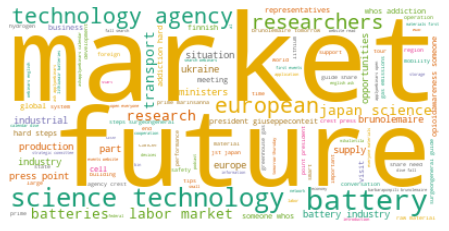

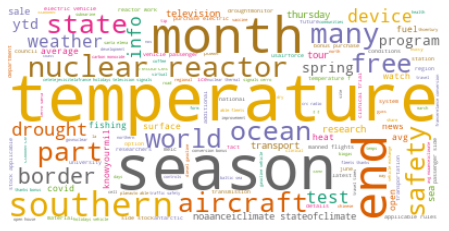

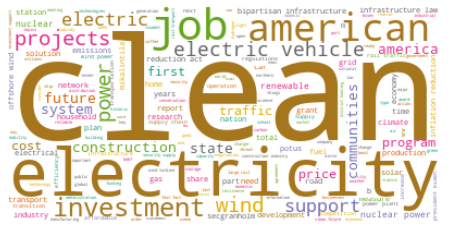

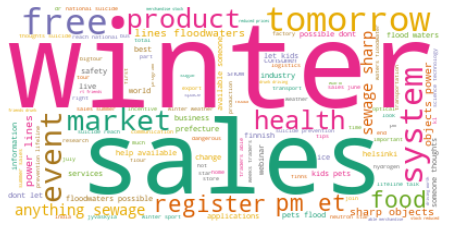

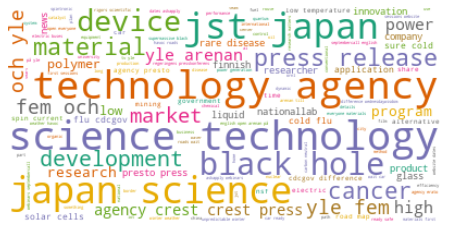

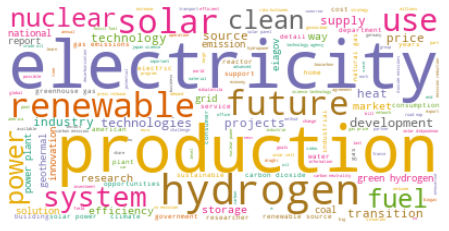

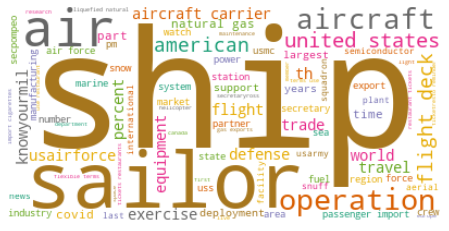

In [ ]:
# create wordclouds for topics within green energy
#figure_dir = "plots/ge_topic_model"

# word clouds from: https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/2-Exploratory-Data-Analysis.ipynb
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [8,4]

for topic in range(NB_GE_TOPICS):
    words_this_topic = green_energy_tweets.where(green_energy_tweets.GE_topic==topic).dropna().nouns_adjs
    filtered_words = [item for subl in words_this_topic for item in subl if item not in ['new', 'amp', 'day', 'year','goal', 'energy', 'sector', 'country', 'finland', 'costa', 'rica','usnavy','project','companies', 'minister', 'energy','today']]
    words_this_topic = " ".join(filtered_words)
    wc.generate(words_this_topic)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    #plt.savefig(figure_dir + '/wordcloud_topic_' + str(topic) + '.png')
    plt.show()

In [ ]:
#topic_dict = {'0': 'carbon', '1': 'transportation', '2': 'renewable energy', '3': 'hydrogen', '4': '(noise)', '5': 'e-vehicle', '6': 'climate','7': 'solar','8': 'air-travel'}
topic_dict = {'0': 'e-mobility', '1': 'electricity', '2': 'air-travel', '3': 'science/tech', '4': 'hydrogen', '5': 'solar', '6': 'wind'}


In [ ]:
[topic_dict[str(i)] for i in range(7)]

['e-mobility',
 'electricity',
 'air-travel',
 'science/tech',
 'hydrogen',
 'solar',
 'wind']

##5. topic distributions across the country and government organisation 

In [ ]:
# same analysis as for proportion of GE topics but for subtopics within GE:
country_array_GE, ministry_array_GE = [], []
topic_arrays_GE = [[] for _ in range(8)] # 8 = 7 topics + "undefined"

topic_df_GE = green_energy_tweets.groupby(["Country", "EnglishLabel"]).GE_topic.value_counts()
for country in topic_df_GE.index.get_level_values(0).unique():
    for ministry in topic_df_GE.loc[country].dropna().index.get_level_values(0).unique():
        country_array_GE.append(country)
        ministry_array_GE.append(ministry)
        for topic in range(-1, 7):
            try:
                topic_arrays_GE[topic+1].append(topic_df_GE.loc[country, ministry, topic])
            except:
                topic_arrays_GE[topic+1].append(0)
                pass # not all countries have tweets related to all topics

tweet_topic_df_GE = pd.DataFrame({'country': country_array_GE, 'ministry': ministry_array_GE})
for topic in range(-1, 7):
    name = 't' + str(topic)
    tweet_topic_df_GE[name] = topic_arrays_GE[topic+1]
tweet_topic_df_GE.head()



country                                           ministry  t-1  t0  t1  t2  \
0     CRI                          Distance State University    3   1   0   2   
1     CRI                            Export Promotion Agency    7   6   2   5   
2     CRI         Ministry of Economy, Industry and Commerce   15   6  19   0   
3     CRI                 Ministry of Environment and Energy   24   2   2  19   
4     CRI  Ministry of Science, Innovation, Technology an...    0   0  18   4   

   t3  t4  t5  t6  
0   1   0   0   0  
1   7   5   7   4  
2   5   4  11   6  
3   1  11  10   3  
4   0   4   6   8

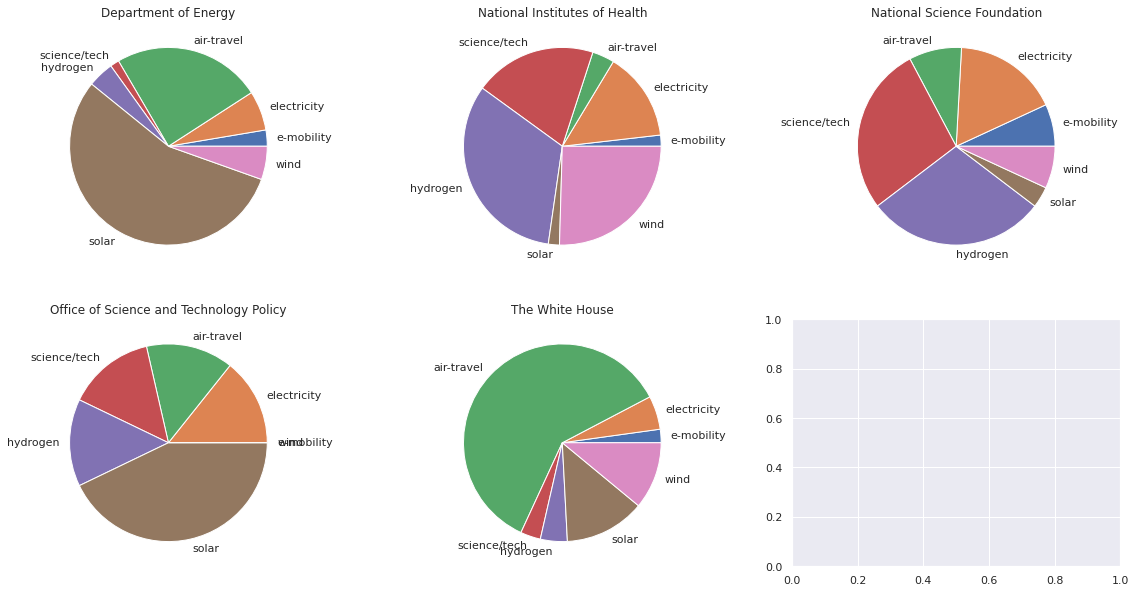

In [ ]:
# Pie chart:
sns.set(font_scale=1)
fig, axs = plt.subplots(2, 3, figsize=(20,10))
country = "USA"
selected_ministries = ['Department of Energy', 'National Institutes of Health',
                       'National Science Foundation', 'Office of Science and Technology Policy', 'The White House']

sub_df_USA = tweet_topic_df_GE.loc[(tweet_topic_df_GE.country==country) & (tweet_topic_df_GE.ministry.isin(selected_ministries))]

for count, min in enumerate(selected_ministries):
    row_idx = count // 3
    col_idx = count % 3
    data = sub_df_USA.loc[sub_df_USA.ministry==min,['t0', 't1', 't2', 't3', 't4', 't5', 't6']].values[0]
    labels = [topic_dict[str(i)] for i in range(7)]
    axs[row_idx][col_idx].pie(x=data, labels=labels)
    axs[row_idx][col_idx].set_title(min)
# sns.set(font_scale=2)
# axs.set_title("Proportion of green energy tweets per US ministry 2019-2022")

# Agreement/Disagreement analysis on replies 

In [ ]:
!pip install transformers

#import packages needed
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoModel, BertTokenizerFast, RobertaTokenizer, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.8 MB/s 
     |████████████████████████████████| 182 kB 67.5 MB/s 
     |████████████████████████████████| 7.6 MB 55.3 MB/s 


## 1. load data

In [ ]:
#import reply tweets file
reply_ministries = pd.read_csv("all_replies_GE_trans.csv").drop(['in_reply_to_user_id',"Unnamed: 0"], axis=1)
reply_ministries = reply_ministries.dropna().reset_index(drop = True)
reply_ministries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29237 entries, 0 to 29236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               29237 non-null  object
 1   id                 29237 non-null  int64 
 2   referenced_tweets  29237 non-null  object
 3   created_at         29237 non-null  object
 4   lang               29237 non-null  object
 5   conversation_id    29237 non-null  int64 
 6   author_id          29237 non-null  int64 
 7   country            29237 non-null  object
 8   retweets           29237 non-null  int64 
 9   likes              29237 non-null  int64 
 10  quotes             29237 non-null  int64 
 11  replies            29237 non-null  int64 
 12  text_en            29237 non-null  object
dtypes: int64(7), object(6)
memory usage: 2.9+ MB


In [ ]:
#seperate the "referenced_tweets" (i.e. the original tweets) to the type of tweet and the original tweet's id
tweet_type = reply_ministries.referenced_tweets.dropna().apply(lambda s: s.split(', ')[0].strip('(').strip("'"))
orig_tweet_id = reply_ministries.referenced_tweets.dropna().apply(lambda s: s.split(', ')[1].strip(')').strip("'"))
reply_ministries['tweet_type'] = tweet_type
reply_ministries['orig_tweet_id'] = orig_tweet_id

#insert a column of cleaned text of reply tweets inside the dataframe
print(reply_ministries.shape)
reply_ministries = reply_ministries.dropna().reset_index(drop=True)
reply_ministries['text_clean'] = reply_ministries.text_en.apply(clean_text)
reply_ministries.head()
print(reply_ministries.shape)

reply_text = reply_ministries['text_clean']
country = reply_ministries['country']
year_created = reply_ministries.created_at.dropna().apply(lambda s: s.split('-')[0])

#divide the tweets into several dataframes and store them in a list (list of dataframes)
l_replies = []
for i in range(0, len(reply_text),round(len(reply_text)/100)):
  l_replies.append(i)

list_of_reply_df = [reply_text.iloc[l_replies[n]:l_replies[n+1]] for n in range(len(l_replies)-1)]

#tweet_origin = green_energy_tweets.copy()

#tweet_origin['created_at'] = year_created
#tweet_origin['id'] = [int(_) for _ in tweet_origin['id']]

(29237, 15)
(29237, 16)


## 2. load the pre-trained model

In [ ]:
# Load the BERT tokenizer and base model
base_model = 'climatebert/distilroberta-base-climate-f' 
tokenizer = AutoTokenizer.from_pretrained(base_model)
auto_model = AutoModelForSequenceClassification.from_pretrained(base_model,
                                                              num_labels=3,
                                                                )

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of the model checkpoint at climatebert/distilroberta-base-climate-f were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifi

In [ ]:
#define the class of Model
import torch.nn as nn 
class Model(nn.Module):

    def __init__(self, model):
        super(Model, self).__init__()

        self.bert = model

        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      output = self.bert(sent_id, attention_mask=mask, return_dict=False)

      # apply softmax activation
      x = self.softmax(output[0])
      return x

In [ ]:
#import the sentiment analysis model
model = Model(auto_model)
model.load_state_dict(torch.load('SA_model.pt', map_location=torch.device('cuda')))

<All keys matched successfully>

## 3. predict agreement/disagreement on reply tweets

In [ ]:
#predicting the emotions of reply tweets 
#0 ---> neutral
#1 ---> disagreement
#2 ---> agreement

device = torch.device("cuda")

predict_reply = []
for df in list_of_reply_df:
  tokens_reply_test = tokenizer.batch_encode_plus(
    df.tolist(),
    max_length = 280,
    pad_to_max_length=True,
    truncation=True)
  en_reply_seq = torch.tensor(tokens_reply_test['input_ids']).cuda()
  en_reply_mask = torch.tensor(tokens_reply_test['attention_mask']).cuda()
  
  model.to(device)

  with torch.no_grad():
    preds_reply = model(en_reply_seq.to(device), en_reply_mask.to(device))
    preds_reply = preds_reply.detach().cpu().numpy()

  #print('prediction done!')

  predict_reply.append(preds_reply)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#generate the final prediction of emotions of reply tweets
predict_reply = np.array(predict_reply)
predict_reply.shape

(100, 292, 3)

In [ ]:
#create reply df with emotion information
emotion = np.argmax(predict_reply, axis=2).flatten()
emotion = pd.DataFrame(emotion)
emotion.insert(0, "Text", reply_text, True)
emotion.insert(0, "Year", year_created, True)
emotion.insert(0, "Country", country, True)
emotion.columns=["Country","Year",'Text','Emotion']
emotion['original_tweet'] = reply_ministries['orig_tweet_id']

to_merge = pd.DataFrame({'id': green_energy_tweets['id'], 'ge_topic': green_energy_tweets.GE_topic, 'ministry': green_energy_tweets.EnglishLabel})
# emotion.merge(to_merge, left_on='original_tweet', right_on = 'id').head()
emotion['id'] = emotion.original_tweet.apply(lambda x: int(x))
reply_emotion = emotion.merge(to_merge, on = 'id')
reply_emotion.head()



Country  Year                                               Text  Emotion  \
0     CRI  2020  alertacomerciales covid drives fresh food pack...        0   
1     CRI  2019  procomercr esencialcr congratulations and than...        2   
2     CRI  2021                this presentation is about to start        0   
3     CRI  2022  integrated approach seeks to optimize the nati...        0   
4     CRI  2020  on the way to the electrification of public tr...        0   

        original_tweet                   id  ge_topic  \
0  1290397715143196672  1290397715143196672         5   
1  1180121152875827200  1180121152875827200         5   
2  1410966826465566720  1410966826465566720         1   
3  1582830102810796032  1582830102810796032         5   
4  1336462447352418304  1336462447352418304        -1   

                                     ministry  
0                     Export Promotion Agency  
1                     Export Promotion Agency  
2  Ministry of Economy, Industry and Commerce  
3          Ministry of Environment and Energy  
4          Ministry of Environment and Energy

## 4. Visualisation 

* reply analysis across 6 countries
* reply analysis on Department of Energy (USA)

**Reply analysis across 6 countries**

In [ ]:
#make a dictionary which stores the countries with each emotion seperated
dct = {}
emotion = reply_emotion.copy()
emotion = emotion.drop(['Text', 'id', 'ge_topic', 'original_tweet'],axis=1)

#groupby the original tweet id and check for each tweet how many neutral, disagreement and agreement it has
df_emotion = pd.concat([emotion,pd.get_dummies(emotion.Emotion)], axis=1).groupby(["Country", 'Year']).sum()
df_emotion = df_emotion.drop(columns = ['Emotion'])
df_emotion.columns=["Emotion0",'Emotion1','Emotion2']
df_emotion = df_emotion.reset_index()

df_emotion = df_emotion.dropna()
for country in df_emotion['Country'].unique():
  keys = [country + '_Emotion' + str(i) for i in range(3)]
  for key in keys:
    dct[key] = dict()
  for year in df_emotion['Year'].unique():
    dct[keys[0]][int(year)] = df_emotion.loc[(df_emotion.Country==country) & (df_emotion.Year==year)]['Emotion0'].sum()
    dct[keys[1]][int(year)] = df_emotion.loc[(df_emotion.Country==country) & (df_emotion.Year==year)]['Emotion1'].sum()
    dct[keys[2]][int(year)] = df_emotion.loc[(df_emotion.Country==country) & (df_emotion.Year==year)]['Emotion2'].sum()

df = pd.DataFrame.from_dict(dct)
df.head()

CRI_Emotion0  CRI_Emotion1  CRI_Emotion2  DEU_Emotion0  DEU_Emotion1  \
2019          13.0           2.0           1.0          44.0           4.0   
2020           6.0           0.0           0.0          18.0          10.0   
2021           1.0           0.0           0.0          20.0           2.0   
2022           1.0           0.0           0.0         215.0          74.0   

      DEU_Emotion2  FIN_Emotion0  FIN_Emotion1  FIN_Emotion2  FRA_Emotion0  \
2019           2.0         171.0          13.0          12.0         257.0   
2020           2.0         251.0          16.0          10.0          54.0   
2021           0.0          62.0           6.0           1.0         187.0   
2022           3.0         389.0          57.0          22.0         105.0   

      ...  FRA_Emotion2  ITA_Emotion0  ITA_Emotion1  ITA_Emotion2  \
2019  ...           0.0           8.0           1.0           0.0   
2020  ...           9.0          34.0           2.0           0.0   
2021  ...          17.0          11.0           0.0           0.0   
2022  ...          18.0         176.0          33.0           9.0   

      JPN_Emotion0  JPN_Emotion1  JPN_Emotion2  USA_Emotion0  USA_Emotion1  \
2019          59.0           0.0           0.0        1196.0         216.0   
2020          42.0           5.0           5.0        2196.0         546.0   
2021          44.0           2.0           1.0        1627.0         392.0   
2022         110.0          28.0           0.0       13557.0        5385.0   

      USA_Emotion2  
2019          60.0  
2020         143.0  
2021          74.0  
2022         399.0  

[4 rows x 21 columns]

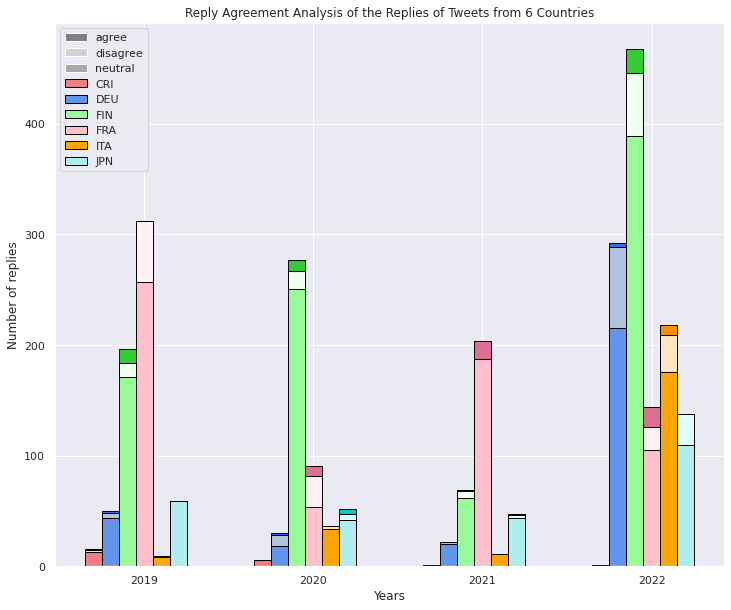

In [ ]:
#light color -> emotion0 (agree), medium color -> emotion1 (disagree), dark color -> emotion2 (neutral)
N = 4
ind = np.arange(N)
width = 0.1

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,1, figsize=(12,10))

ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='grey', label = 'agree')
ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='lightgrey', label = 'disagree')
ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='darkgrey', label = 'neutral')

ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='indianred', edgecolor='black')
ax.bar(ind - 2 * width, df[df.columns[3+2]]+df[df.columns[3+1]]+df[df.columns[3]], align='center', width=width, color='royalblue', edgecolor='black')
ax.bar(ind - width, df[df.columns[6+2]]+df[df.columns[6+1]]+df[df.columns[6]], align='center', width=width, color='limegreen', edgecolor='black')
ax.bar(ind, df[df.columns[9+2]]+df[df.columns[9+1]]+df[df.columns[9]], align='center', width=width, color='palevioletred', edgecolor='black')
ax.bar(ind + width, df[df.columns[12+2]]+df[df.columns[12+1]]+df[df.columns[12]], align='center', width=width, color='darkorange', edgecolor='black')
ax.bar(ind + 2 * width, df[df.columns[15+2]]+df[df.columns[15+1]]+df[df.columns[15]], align='center', width=width, color='darkturquoise', edgecolor='black')
# ax.bar(ind + 3 * width, df[df.columns[18+2]]+df[df.columns[18+1]]+df[df.columns[18]], align='center', width=width, color='lightgray')

ax.bar(ind - 3 * width, df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='mistyrose', edgecolor='black')
ax.bar(ind - 2 * width, df[df.columns[3+1]]+df[df.columns[3]], align='center', width=width, color='lightsteelblue', edgecolor='black')
ax.bar(ind - width, df[df.columns[6+1]]+df[df.columns[6]], align='center', width=width, color='honeydew', edgecolor='black')
ax.bar(ind, df[df.columns[9+1]]+df[df.columns[9]], align='center', width=width, color='lavenderblush', edgecolor='black')
ax.bar(ind + width, df[df.columns[12+1]]+df[df.columns[12]], align='center', width=width, color='bisque', edgecolor='black')
ax.bar(ind + 2 * width, df[df.columns[15+1]]+df[df.columns[15]], align='center', width=width, color='lightcyan', edgecolor='black')
# ax.bar(ind + 3 * width, df[df.columns[18+1]]+df[df.columns[18]], align='center', width=width, color='darkgray')

ax.bar(ind - 3 * width, df[df.columns[0]], align='center', width=width, color='lightcoral', label = 'CRI', edgecolor='black')
ax.bar(ind - 2 * width, df[df.columns[3]], align='center', width=width, color='cornflowerblue', label = 'DEU', edgecolor='black')
ax.bar(ind - width, df[df.columns[6]], align='center', width=width, color='palegreen', label = 'FIN', edgecolor='black')
ax.bar(ind, df[df.columns[9]], align='center', width=width, color='pink', label = 'FRA', edgecolor='black')
ax.bar(ind + width, df[df.columns[12]], align='center', width=width, color='orange', label = 'ITA', edgecolor='black')
ax.bar(ind + 2 * width, df[df.columns[15]], align='center', width=width, color = 'paleturquoise', label = 'JPN', edgecolor='black')
# ax.bar(ind + 3 * width, df[df.columns[18]], align='center', width=width, color='gray', label = topic_dict['6'])

plt.xlabel("Years")
plt.ylabel('Number of replies')
plt.title("Reply Agreement Analysis of the Replies of Tweets from 6 Countries")
plt.xticks([0, 1, 2, 3],['2019', '2020', '2021', '2022'])

plt.legend()

plt.show()

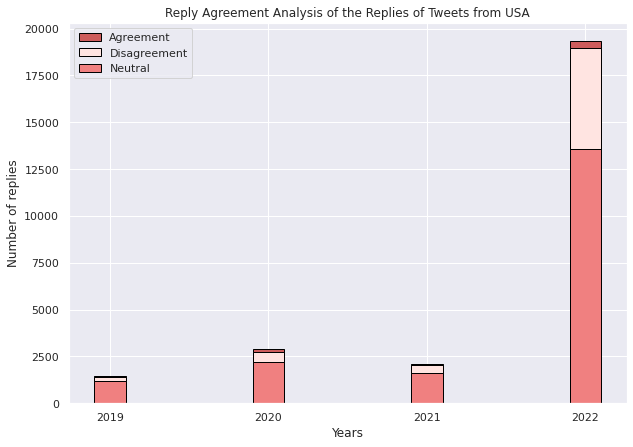

In [ ]:
# US only:

df_usa = df[['USA_Emotion0', 'USA_Emotion1', 'USA_Emotion2']]

N = 4
ind = np.arange(N)
width = 0.2

plt.rcParams['figure.figsize'] = [10,7]


#mistyrose(light), lightcoral(medium), indianred(dark)
plt.bar(ind, df_usa[df_usa.columns[0+2]]+df_usa[df_usa.columns[0+1]]+df_usa[df_usa.columns[0]], align='center', width=width, color='indianred', label = 'Agreement', edgecolor='black')
plt.bar(ind, df_usa[df_usa.columns[0+1]]+df_usa[df_usa.columns[0]], align='center', width=width, color='mistyrose', label = 'Disagreement', edgecolor='black')
plt.bar(ind, df_usa[df_usa.columns[0]], align='center', width=width, color='lightcoral', label = 'Neutral', edgecolor='black')

plt.xlabel("Years")
plt.ylabel('Number of replies')
plt.title("Reply Agreement Analysis of the Replies of Tweets from USA")
plt.xticks([0, 1, 2, 3],['2019', '2020', '2021', '2022'])

plt.legend()

plt.show()

**Reply analysis on Department of Energy, USA**

In [ ]:
import pandas as pd
reply_emotion = pd.read_csv("reply_emotion.csv")

In [ ]:
emotion_doe = reply_emotion.loc[(reply_emotion.Country=='USA') & (reply_emotion.ministry == 'Department of Energy')]
#emotion_doe.groupby('original_tweet')

In [ ]:
emotion_doe.tail()

Unnamed: 0 Country  Year  \
6214        6214     USA  2019   
6215        6215     USA  2019   
6216        6216     USA  2019   
6217        6217     USA  2019   
6218        6218     USA  2019   

                                                   Text  Emotion  \
6214  flow diagram of us energy where it comes from ...        0   
6215                              energy eiagov exactly        0   
6216           energy eiagov lets not forget hydropower        0   
6217  cleaner cheaper cleanenergy windpower windener...        0   
6218  more than half of that is renewables at wind a...        0   

           original_tweet                   id  ge_topic              ministry  
6214  1083760724801921024  1083760724801921024         5  Department of Energy  
6215  1083393537041936384  1083393537041936384         5  Department of Energy  
6216  1083393537041936384  1083393537041936384         5  Department of Energy  
6217  1083393537041936384  1083393537041936384         5  Department of Energy  
6218  1083393537041936384  1083393537041936384         5  Department of Energy

In [ ]:
dct = {}
for top in range(7): # discard unclassified
    this_topic_df = emotion_doe.loc[emotion_doe.ge_topic==top]
    keys = [topic_dict[str(top)] + '_' + 'Emotion' + str(i) for i in range(3)]
    for key in keys:
        dct[key] = dict()
    for year in range(2019, 2023):
        df_this_year = this_topic_df.loc[this_topic_df.Year==year]
        dct[keys[0]][year] =  df_this_year.where(df_this_year.Emotion==0).dropna().shape[0]
        dct[keys[1]][year] =  df_this_year.where(df_this_year.Emotion==1).dropna().shape[0]
        dct[keys[2]][year] =  df_this_year.where(df_this_year.Emotion==2).dropna().shape[0]
            
dct

{'e-mobility_Emotion0': {2019: 0, 2020: 4, 2021: 1, 2022: 15},
 'e-mobility_Emotion1': {2019: 0, 2020: 0, 2021: 0, 2022: 7},
 'e-mobility_Emotion2': {2019: 0, 2020: 0, 2021: 1, 2022: 0},
 'electricity_Emotion0': {2019: 3, 2020: 40, 2021: 0, 2022: 0},
 'electricity_Emotion1': {2019: 2, 2020: 9, 2021: 0, 2022: 0},
 'electricity_Emotion2': {2019: 0, 2020: 0, 2021: 1, 2022: 0},
 'air-travel_Emotion0': {2019: 35, 2020: 59, 2021: 51, 2022: 99},
 'air-travel_Emotion1': {2019: 7, 2020: 8, 2021: 3, 2022: 24},
 'air-travel_Emotion2': {2019: 3, 2020: 2, 2021: 2, 2022: 6},
 'science/tech_Emotion0': {2019: 0, 2020: 0, 2021: 0, 2022: 3},
 'science/tech_Emotion1': {2019: 0, 2020: 0, 2021: 0, 2022: 0},
 'science/tech_Emotion2': {2019: 0, 2020: 0, 2021: 0, 2022: 0},
 'hydrogen_Emotion0': {2019: 15, 2020: 7, 2021: 4, 2022: 0},
 'hydrogen_Emotion1': {2019: 3, 2020: 0, 2021: 1, 2022: 0},
 'hydrogen_Emotion2': {2019: 0, 2020: 1, 2021: 0, 2022: 0},
 'solar_Emotion0': {2019: 148, 2020: 131, 2021: 57, 2022: 1

In [ ]:
df = pd.DataFrame.from_dict(dct)
df.head()

e-mobility_Emotion0  e-mobility_Emotion1  e-mobility_Emotion2  \
2019                    0                    0                    0   
2020                    4                    0                    0   
2021                    1                    0                    1   
2022                   15                    7                    0   

      electricity_Emotion0  electricity_Emotion1  electricity_Emotion2  \
2019                     3                     2                     0   
2020                    40                     9                     0   
2021                     0                     0                     1   
2022                     0                     0                     0   

      air-travel_Emotion0  air-travel_Emotion1  air-travel_Emotion2  \
2019                   35                    7                    3   
2020                   59                    8                    2   
2021                   51                    3                    2   
2022                   99                   24                    6   

      science/tech_Emotion0  ...  science/tech_Emotion2  hydrogen_Emotion0  \
2019                      0  ...                      0                 15   
2020                      0  ...                      0                  7   
2021                      0  ...                      0                  4   
2022                      3  ...                      0                  0   

      hydrogen_Emotion1  hydrogen_Emotion2  solar_Emotion0  solar_Emotion1  \
2019                  3                  0             148              17   
2020                  0                  1             131              27   
2021                  1                  0              57               6   
2022                  0                  0            1060             357   

      solar_Emotion2  wind_Emotion0  wind_Emotion1  wind_Emotion2  
2019               6             65             19              1  
2020              12              8              4              0  
2021               1              0              0              0  
2022              43              0              0              0  

[4 rows x 21 columns]

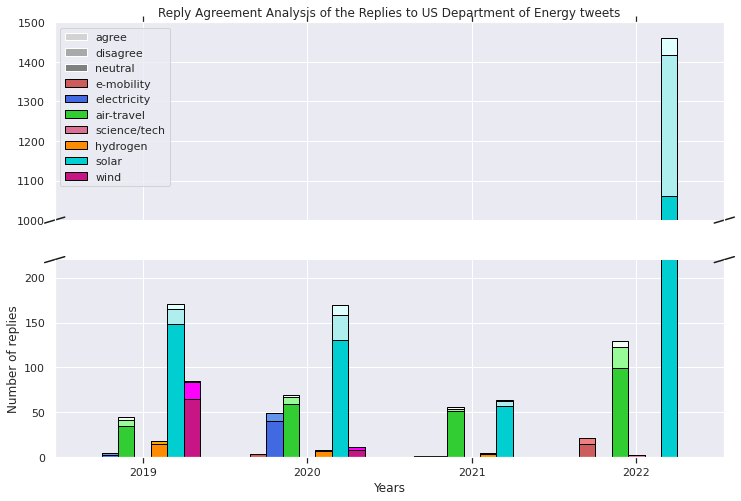

In [ ]:
# visualize public's reaction (agreemnet/disagreement) on tweets by DOE 
import matplotlib.pyplot as plt
import numpy as np
#light color -> emotion0, medium color -> emotion1, dark color -> emotion2

N = 4
ind = np.arange(N)
width = 0.1

plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size': 11.5})

# ALTERNATIVE PLOT:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for ax in [ax1, ax2]:
    ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='lightgrey', label = 'agree')
    ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='darkgrey', label = 'disagree')
    ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='grey', label = 'neutral')

    ax.bar(ind - 3 * width, df[df.columns[0+2]]+df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='mistyrose', edgecolor='black')
    ax.bar(ind - 2 * width, df[df.columns[3+2]]+df[df.columns[3+1]]+df[df.columns[3]], align='center', width=width, color='lightsteelblue', edgecolor='black')
    ax.bar(ind - width, df[df.columns[6+2]]+df[df.columns[6+1]]+df[df.columns[6]], align='center', width=width, color='honeydew', edgecolor='black')
    ax.bar(ind, df[df.columns[9+2]]+df[df.columns[9+1]]+df[df.columns[9]], align='center', width=width, color='lavenderblush', edgecolor='black')
    ax.bar(ind + width, df[df.columns[12+2]]+df[df.columns[12+1]]+df[df.columns[12]], align='center', width=width, color='bisque', edgecolor='black')
    ax.bar(ind + 2 * width, df[df.columns[15+2]]+df[df.columns[15+1]]+df[df.columns[15]], align='center', width=width, color='lightcyan', edgecolor='black')
    ax.bar(ind + 3 * width, df[df.columns[18+2]]+df[df.columns[18+1]]+df[df.columns[18]], align='center', width=width, color='plum', edgecolor='black')

    ax.bar(ind - 3 * width, df[df.columns[0+1]]+df[df.columns[0]], align='center', width=width, color='lightcoral', edgecolor='black')
    ax.bar(ind - 2 * width, df[df.columns[3+1]]+df[df.columns[3]], align='center', width=width, color='cornflowerblue', edgecolor='black')
    ax.bar(ind - width, df[df.columns[6+1]]+df[df.columns[6]], align='center', width=width, color='palegreen', edgecolor='black')
    ax.bar(ind, df[df.columns[9+1]]+df[df.columns[9]], align='center', width=width, color='pink', edgecolor='black')
    ax.bar(ind + width, df[df.columns[12+1]]+df[df.columns[12]], align='center', width=width, color='orange', edgecolor='black')
    ax.bar(ind + 2 * width, df[df.columns[15+1]]+df[df.columns[15]], align='center', width=width, color='paleturquoise', edgecolor='black')
    ax.bar(ind + 3 * width, df[df.columns[18+1]]+df[df.columns[18]], align='center', width=width, color='magenta', edgecolor='black')

    ax.bar(ind - 3 * width, df[df.columns[0]], align='center', width=width, color='indianred', label = topic_dict['0'], edgecolor='black')
    ax.bar(ind - 2 * width, df[df.columns[3]], align='center', width=width, color='royalblue', label = topic_dict['1'], edgecolor='black')
    ax.bar(ind - width, df[df.columns[6]], align='center', width=width, color='limegreen', label = topic_dict['2'], edgecolor='black')
    ax.bar(ind, df[df.columns[9]], align='center', width=width, color='palevioletred', label = topic_dict['3'], edgecolor='black')
    ax.bar(ind + width, df[df.columns[12]], align='center', width=width, color='darkorange', label = topic_dict['4'], edgecolor='black')
    ax.bar(ind + 2 * width, df[df.columns[15]], align='center', width=width, color = 'darkturquoise', label = topic_dict['5'], edgecolor='black')
    ax.bar(ind + 3 * width, df[df.columns[18]], align='center', width=width, color='mediumvioletred', label = topic_dict['6'], edgecolor='black')

ax2.set_xlabel("Years")
ax2.set_ylabel('Number of replies')
ax1.set_title("Reply Agreement Analysis of the Replies to US Department of Energy tweets")
ax2.set_xticks([0, 1, 2, 3])
ax2.set_xticklabels(['2019', '2020', '2021', '2022'])

ax1.legend()

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(1000, 1500)  # outliers only
ax2.set_ylim(0, 220)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

In [ ]:
# visualize the topics of tweets by DOE 

Text(0.5, 1.0, 'Number of posts by topic US Department of Energy')

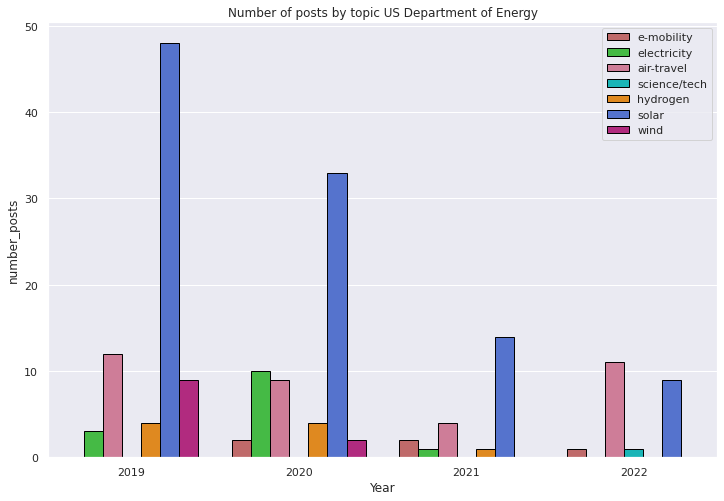

In [ ]:
# number of tweets per topic in DoE tweets:
# Create an array with the colors you want to use
colors = ["indianred", "limegreen", "palevioletred", "darkturquoise", "darkorange", "royalblue","mediumvioletred"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
plt.rcParams.update({'font.size': 16})


per_year_and_topic = reply_emotion.loc[(reply_emotion.Country=='USA') & (reply_emotion.ministry=='Department of Energy') & (reply_emotion.ge_topic!= -1)].groupby(['ge_topic', 'Year']).original_tweet.nunique().reset_index(name ='number_posts')
ge_topics_named = per_year_and_topic.ge_topic.apply(lambda x: topic_dict[str(x)])
per_year_and_topic['named_topic'] = ge_topics_named
sns.barplot(data=per_year_and_topic, x='Year', y='number_posts', hue='named_topic',edgecolor='black')
plt.legend(loc='upper right')
plt.title('Number of posts by topic US Department of Energy')
# per_year_and_topic